### Imports 

In [2]:
import os 
import re 
import numpy as np 
import pandas as pd 
from collections import Counter

### Data prep

#### File import

In [3]:
def combine_files_into_df(directory_path="../data/", file_types=['.parquet', '.tsv', '.csv']):
    """
    Combines all files in a specified directory into one DataFrame based on specified file types.

    Parameters:
    directory_path (str): Path to the directory containing the files.
    file_types (list): List of file extensions to include in the combination (e.g., ['.parquet', '.tsv', '.csv']).

    Returns:
    pd.DataFrame: A DataFrame consisting of combined data from files in the specified directory.
    """
    # Map file extensions to their respective pandas read functions and parameters
    read_funcs = {
        '.parquet': (pd.read_parquet, {'engine': 'fastparquet'}),
        '.tsv': (pd.read_csv, {'sep': '\t'}),
        '.csv': (pd.read_csv, {})
    }
    
    message_prefix = "Step 1/? complete."

    dfs = []
    # Iterate through all files in the specified directory
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        file_extension = os.path.splitext(file)[1]
        
        # Check if the file extension is in the list of types to read
        if file_extension in file_types:
            read_func, params = read_funcs.get(file_extension, (None, None))
            if read_func:
                df = read_func(file_path, **params)
                dfs.append(df)
            else:
                print(f"Skipping unsupported file type: {file_extension}")

    # Combine all DataFrames in the list into a single DataFrame
    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        print(f"{message_prefix} Combined {len(dfs)} files into one DataFrame.")
    else:
        df = pd.DataFrame()
        print("No files combined.")

    return df

In [4]:
def filter_andromeda_score(df, threshold=70):
    """
    Filters out rows in the DataFrame where the andromeda_score is less than 70.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with rows where andromeda_score >= 70.
    """
    # Filter the DataFrame
    filtered_df = df[df['andromeda_score'] >= threshold]
    return filtered_df

In [5]:
def filter_dataframe_columns(df, columns_to_keep=['modified_sequence', 'precursor_charge', 'precursor_intensity']):
    """
    Filters a DataFrame to retain only the specified columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to filter.
    columns_to_keep (list): The names of the columns to keep in the DataFrame.

    Returns:
    pd.DataFrame: A DataFrame containing only the specified columns.
    """
    filtered_df = df[columns_to_keep].copy() if all(col in df for col in columns_to_keep) else df
#    print(f"Step 2/? complete. Removed {len(df.columns) - len(df_filtered.columns)} columns from the DataFrame.")
    return filtered_df

In [6]:
def drop_na(df, column="precursor_intensity"):
    """
    Drops all rows with NaN values in a specific column of the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame from which to drop rows.
    column (str): The column name where NaN values will be checked and rows dropped accordingly.

    Returns:
    pd.DataFrame: A DataFrame without NaN values in the specified column.
    """
    filtered_df = df[df[column].notna()]
#    print(f"Step 3/? complete. Dropped rows with NaN for intensities.")
    return filtered_df

In [7]:
def keep_desired_charges(df, charge_list=[1, 2, 3, 4, 5, 6], min_count=None):
    """
    Keep only desired charge states and filter out charges with counts less than min_count.
    Default: keep charge states 1-6 with no minimum count filtering.

    @param df: DataFrame
    @param charge_list: list of charge states to be kept
    @param min_count: minimum count of charge states to be retained
    """
    if min_count is not None:
        charge_counts = df["precursor_charge"].value_counts()
        charge_list = [
            charge for charge in charge_list if charge_counts.get(charge, 0) >= min_count
        ]

    filtered_df = df[df["precursor_charge"].isin(charge_list)]
    return filtered_df

In [8]:
def aggregate_unique_sequences(df):
    """
    Aggregates all sequences to unique sequences
    @param df: DataFrame
    @return: df: DataFrame
    """
    df = (
        df.groupby("modified_sequence", as_index=False)[["precursor_charge", "precursor_intensity"]]
        .agg(list)
    )
    # print(f"Step 5/? complete. Aggregated all sequences to unique sequences.")
    return df

In [9]:
def remove_rare_sequence_lengths(df, representation_threshold=100):
    """
    Remove sequences of specific length represented less than a certain number of times.
    
    @param df: DataFrame containing a "modified_sequence" column
    @param representation_threshold: int, threshold for the number of times a sequence length must be represented
    @return: tuple of (DataFrame, int), where DataFrame contains only sequence lengths represented more than
             representation_threshold times, and int is the length of the longest sequence
    """
    before_len = len(df)
    # Calculate sequence lengths directly within the groupby and count operation
    sequence_lengths = df["modified_sequence"].str.len()
    # Identify sequence lengths that meet the representation threshold
    valid_lengths = sequence_lengths.value_counts()[lambda x: x >= representation_threshold].index
    # Filter the DataFrame based on valid sequence lengths
    filtered_df = df[sequence_lengths.isin(valid_lengths)].copy()
    padding_length = sequence_lengths.max()
    after_len = len(filtered_df)
    
    '''
    print(
        f"Step 6/? complete. Removed {before_len - after_len} of {before_len} sequences because their sequence length "
        f"is represented less than {representation_threshold} times."
    )
    '''
    return filtered_df, padding_length

In [10]:
def complete_vocabulary(df):
    """
    Find all UNIMOD annotations and add them to the vocabulary
    (The length of the vocabulary +1 is used later for the embedding layer)
    @param df: DataFrame
    @return: vocabulary: list, list of all amino acids and modifications
    @return: vocab_len: int, length of the vocabulary
    """
    vocabulary = []
    vocabulary += list("XACDEFGHIKLMNPQRSTVWY")
    annotations = re.findall(r"(\w\[UNIMOD:\d+])", " ".join(df["modified_sequence"]))
    for item in annotations:
        if item not in vocabulary:
            vocabulary.append(item)
    
    # print(f"Step 7/? complete. Completed vocabulary with {vocab_len} entries.")
    return vocabulary, len(vocabulary)

## Select most abundand charge states for TASK 1

### By count // OBSOLETE

In [11]:
def select_most_abundant_by_count(df, charge_list=None):
    """
    Selects the most abundant charge state by count.
    
    @param df: DataFrame with a 'precursor_charge' column containing a list of charge states.
    @return: DataFrame with an added 'most_abundant_by_count' and 'most_abundant_charge_vector' column.
    """
    # Define a function to find the most common element in a list
    def most_common(lst):
        return Counter(lst).most_common(1)[0][0]

    # Apply the function to each row in the 'precursor_charge' column and assign to a new column
    df['most_abundant_charge_by_count'] = df['precursor_charge'].apply(most_common)

    if charge_list is None:
        charge_list = [1, 2, 3, 4, 5, 6]
    df["most_abundant_charge_by_count_vector"] = df["most_abundant_charge_by_count"].apply(
        lambda x: [1 if x == i else 0 for i in charge_list]
    )
    '''
    print(
        f"Step ?/? complete. Selected most abundant charge state by count and generated one-hot encoding"
    )
    '''
    
    return df

In [12]:
def get_topK_charge_states_by_count(df, k=2):
    """
    Get top-k charge states for each sequence according to the count in precursor_charge.
    Default: k=2
    @param df: DataFrame with a 'precursor_charge' column containing a list of charge states.
    @param k: int, number of top charge states to be selected
    @return: DataFrame with an added column for top-k charge states.
    """

    def get_topK_charge_counts(charge_list):
        # Count the occurrences of each charge state and get the top-k
        count = Counter(charge_list)
        top_k = [charge for charge, _ in count.most_common(k)]
        return top_k

    # Apply the function to each row in the 'precursor_charge' column and assign to a new column
    df[f"top_{k}_charge_states_by_count"] = df['precursor_charge'].apply(get_topK_charge_counts)

    # print(f"Step ?/? complete. Selected top {k} charge states per sequence based on count.")
    return df

### By intensities

In [13]:
def select_most_abundant_charge_by_intensity(df, aggregation='max'):
    charge_col = f'charge_by_{aggregation}_intensity'
    intensity_col = f'{aggregation}_intensity'
    df[charge_col] = None
    df[intensity_col] = None

    for index, row in df.iterrows():
        charges = row['precursor_charge']
        intensities = row['precursor_intensity']

        # Aggregate intensities for each unique charge
        charge_intensity_dict = {}
        for charge, intensity in zip(charges, intensities):
            if charge in charge_intensity_dict:
                charge_intensity_dict[charge].append(intensity)
            else:
                charge_intensity_dict[charge] = [intensity]

        # Calculate the average or maximum intensity for each charge
        if aggregation == 'avg':
            avg_intensity = {charge: sum(charge_intensity_dict[charge]) / len(charge_intensity_dict[charge]) for charge in charge_intensity_dict}
            most_abundant_charge = max(avg_intensity, key=avg_intensity.get)
            selected_intensity = avg_intensity[most_abundant_charge]
        elif aggregation == 'max':
            max_intensity = {charge: max(charge_intensity_dict[charge]) for charge in charge_intensity_dict}
            most_abundant_charge = max(max_intensity, key=max_intensity.get)
            selected_intensity = max_intensity[most_abundant_charge]

        df.at[index, charge_col] = most_abundant_charge
        df.at[index, intensity_col] = selected_intensity

    return df

In [14]:
def top_k_abundant_charges_by_intensity(df, k=1, aggregation='max'):
    charge_col = f'top_{k}_abundant_charges_by_{aggregation}'
    intensity_col = f'top_{k}_{aggregation}_intensities'
    df[charge_col] = None
    df[intensity_col] = None

    for index, row in df.iterrows():
        charges = row['precursor_charge']
        intensities = row['precursor_intensity']

        # Aggregate intensities for each unique charge
        charge_intensity_dict = {}
        for charge, intensity in zip(charges, intensities):
            charge_intensity_dict.setdefault(charge, []).append(intensity)

        # Calculate the average or maximum intensity for each charge
        if aggregation == 'avg':
            charge_intensity_aggregated = {charge: sum(intensities) / len(intensities) for charge, intensities in charge_intensity_dict.items()}
        elif aggregation == 'max':
            charge_intensity_aggregated = {charge: max(intensities) for charge, intensities in charge_intensity_dict.items()}

        # Sort the charges by their aggregated intensity and select the top-k
        sorted_charges = sorted(charge_intensity_aggregated.items(), key=lambda item: item[1], reverse=True)[:k]
        top_k_charges, top_k_intensities = zip(*sorted_charges) if sorted_charges else ([], [])
        
        df.at[index, charge_col] = list(top_k_charges)
        df.at[index, intensity_col] = list(top_k_intensities)

    return df

In [15]:
def generate_charge_state_encodings(df, aggregation='max'):
    '''
    Calculate the most abundant charge state for each sequence based on the precursor intensity
    and generate the charge state vector and one-hot encoded vector for the most abundant charge.
    '''
    df['one_hot_most_abundant_charge'] = None
    df['charge_state_vector'] = None

    max_charge_state = max(max(charges) for charges in df['precursor_charge'])

    for index, row in df.iterrows():
        charges = row['precursor_charge']
        intensities = row['precursor_intensity']

        # Map intensities to their respective charge states
        charge_intensity_dict = {charge: [] for charge in charges}
        for charge, intensity in zip(charges, intensities):
            charge_intensity_dict[charge].append(intensity)

        # Aggregate intensities
        if aggregation == 'avg':
            aggregated_intensity = {charge: sum(intensities) / len(intensities) for charge, intensities in charge_intensity_dict.items()}
        else:  # max
            aggregated_intensity = {charge: max(intensities) for charge, intensities in charge_intensity_dict.items()}
        
        most_abundant_charge = max(aggregated_intensity, key=aggregated_intensity.get)

        # Generate the one-hot encoded vector for the most abundant charge
        one_hot_vector = [1 if charge == most_abundant_charge else 0 for charge in range(1, max_charge_state + 1)]
        
        # Generate the charge state vector for all charges
        charge_state_vector = [1 if charge in charges else 0 for charge in range(1, max_charge_state + 1)]

        df.at[index, 'one_hot_most_abundant_charge'] = one_hot_vector
        df.at[index, 'charge_state_vector'] = charge_state_vector

    return df

In [16]:
def compute_normalized_intensity_distribution(df):
    '''
    TASK 3: Compute the normalized intensity distribution for each sequence.
    '''

    max_charge_state = max(max(charges) for charges in df['precursor_charge'])

    normalized_intensity_distribution = []
    for charges, intensities in zip(df['precursor_charge'], df['precursor_intensity']):
        total_intensity = sum(intensities)
        charge_intensity_dict = {charge: 0 for charge in range(1, max_charge_state + 1)}
        for charge, intensity in zip(charges, intensities):
            charge_intensity_dict[charge] += intensity

        distribution = [charge_intensity_dict[i] / total_intensity for i in range(1, max_charge_state + 1)]
        normalized_intensity_distribution.append(distribution)
    
    df['normalized_intensity_distribution'] = normalized_intensity_distribution
    return df

In [17]:
def save_df_as_parquet(df, data_dir, file_name='preprocessed_pcp_data.parquet'):
    """
    Saves a DataFrame as a Parquet file in the specified directory with the given file name.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    data_dir (str): Directory where the Parquet file will be saved.
    file_name (str, optional): Name of the Parquet file. Defaults to 'preprocessed_pcp_data.parquet'.
    """
    # Ensure the directory exists
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # Full path for the file
    file_path = os.path.join(data_dir, file_name)
    
    # Save the DataFrame as a Parquet file
    df.to_parquet(file_path, engine='pyarrow')

    print(f"File saved successfully at {file_path}")

## Data prep process

In [18]:
df = combine_files_into_df()

Step 1/? complete. Combined 12 files into one DataFrame.


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61727023 entries, 0 to 61727022
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   raw_file                  object 
 1   scan_number               int64  
 2   modified_sequence         object 
 3   precursor_charge          int64  
 4   precursor_intensity       float64
 5   mz                        float64
 6   precursor_mz              float64
 7   fragmentation             object 
 8   mass_analyzer             object 
 9   retention_time            float64
 10  indexed_retention_time    float64
 11  andromeda_score           float64
 12  peptide_length            int64  
 13  orig_collision_energy     float64
 14  aligned_collision_energy  float64
dtypes: float64(8), int64(3), object(4)
memory usage: 6.9+ GB


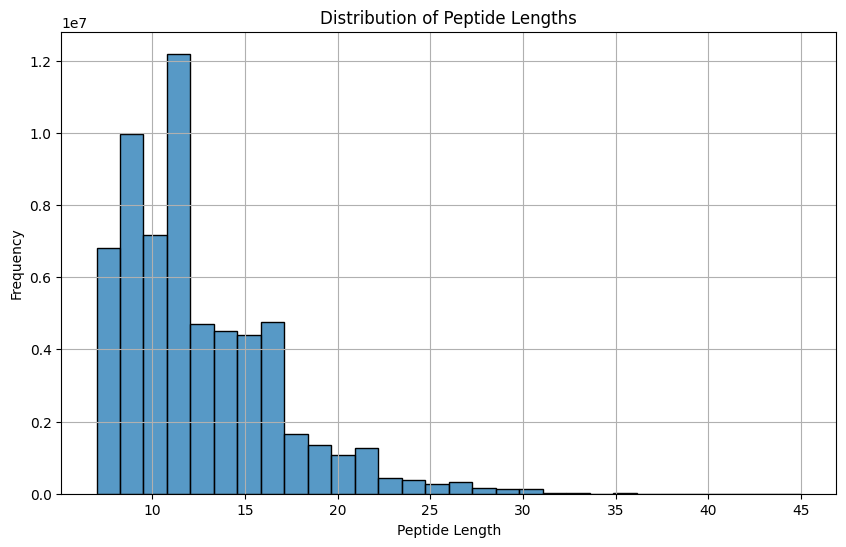

In [22]:
# plot peptide_length distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['peptide_length'], bins=30, kde=False)
plt.title('Distribution of Peptide Lengths')
plt.xlabel('Peptide Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [55]:
df = filter_andromeda_score(df)

In [56]:
df = filter_dataframe_columns(df)

In [57]:
df = drop_na(df)

In [58]:
df = keep_desired_charges(df, charge_list=[1,2,3,4,5,6,7], min_count=10000)

In [59]:
df = aggregate_unique_sequences(df)

In [60]:
df, max_seq_len = remove_rare_sequence_lengths(df, representation_threshold=200)

In [61]:

df = select_most_abundant_charge_by_intensity(df, aggregation='max')

In [62]:
df = select_most_abundant_charge_by_intensity(df, aggregation='avg')

In [63]:
df = generate_charge_state_encodings(df, aggregation='max')

In [64]:
df = compute_normalized_intensity_distribution(df)

In [65]:
df.head()

,modified_sequence,precursor_charge,precursor_intensity,charge_by_max_intensity,max_intensity,charge_by_avg_intensity,avg_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",2,84118390.0,2,43127182.666667,"[0, 1, 0, 0, 0]","[1, 1, 1, 0, 0]","[0.0014942136737631886, 0.977159622342211, 0.0..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",2,8824163.0,2,7635636.714286,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",2,3067981.0,2,3067981.0,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]","[11913300.0, 11913300.0, 11913300.0, 11913300....",2,11913300.0,2,8273927.142857,"[0, 1, 0, 0, 0]","[0, 1, 1, 0, 0]","[0.0, 0.9879325512697509, 0.012067448730249095..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",1,16573010.0,1,8562738.097872,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0]"


In [66]:
len(df)

757164

In [69]:
save_df_as_parquet(df, data_dir='../', file_name='preprocessed_pcp_data.parquet')

File saved successfully at ../preprocessed_pcp_data.parquet


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757164 entries, 0 to 758335
Data columns (total 10 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   modified_sequence                  757164 non-null  object
 1   precursor_charge                   757164 non-null  object
 2   precursor_intensity                757164 non-null  object
 3   charge_by_max_intensity            757164 non-null  object
 4   max_intensity                      757164 non-null  object
 5   charge_by_avg_intensity            757164 non-null  object
 6   avg_intensity                      757164 non-null  object
 7   one_hot_most_abundant_charge       757164 non-null  object
 8   charge_state_vector                757164 non-null  object
 9   normalized_intensity_distribution  757164 non-null  object
dtypes: object(10)
memory usage: 79.7+ MB


## SIMPLIFIED TEST SET

In [26]:
input = {
    "modified_sequence": ["A"]*6 + ["B"]*5 + ["C"]*4 + ["D"]*3 + ["E"]*2 + ["F"]*3 + ["G"]*4 + ["H"]*3 + ["I"]*5 + ["J"] + ["X"]*6,
    "precursor_charge": [2, 2, 2, 1, 3, 2, 2, 2, 1, 1, 3, 1, 1, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2, 4, 4, 4, 4, 5, 2, 1, 1, 1, 1, 2, 2],
    "precursor_intensity": [10, 20, 30, 40, 15, 25, 50, 60, 70, 80, 90, 100, 200, 150, 50, 300, 500, 400, 10, 20, 30, 40, 50, 60, 70, 65, 60, 100, 200, 300, 400, 500, 600, 700, 800, 900, 550, 560, 570, 550, 200, 900]
}
test_data = pd.DataFrame(input)

In [27]:
aggregated_test_data = aggregate_unique_sequences(test_data)
aggregated_test_data = select_most_abundant_charge_by_intensity(aggregated_test_data, aggregation='max')
aggregated_test_data = select_most_abundant_charge_by_intensity(aggregated_test_data, aggregation='avg')
aggregated_test_data = generate_charge_state_encodings(aggregated_test_data, aggregation='max')
aggregated_test_data = compute_normalized_intensity_distribution(aggregated_test_data)
aggregated_test_data

,modified_sequence,precursor_charge,precursor_intensity,charge_by_max_intensity,max_intensity,charge_by_avg_intensity,avg_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,A,"[2, 2, 2, 1, 3, 2]","[10, 20, 30, 40, 15, 25]",1,40,1,40.0,"[1, 0, 0, 0, 0]","[1, 1, 1, 0, 0]","[0.2857142857142857, 0.6071428571428571, 0.107..."
1,B,"[2, 2, 1, 1, 3]","[50, 60, 70, 80, 90]",3,90,3,90.0,"[0, 0, 1, 0, 0]","[1, 1, 1, 0, 0]","[0.42857142857142855, 0.3142857142857143, 0.25..."
2,C,"[1, 1, 2, 2]","[100, 200, 150, 50]",1,200,1,150.0,"[1, 0, 0, 0, 0]","[1, 1, 0, 0, 0]","[0.6, 0.4, 0.0, 0.0, 0.0]"
3,D,"[3, 3, 2]","[300, 500, 400]",3,500,3,400.0,"[0, 0, 1, 0, 0]","[0, 1, 1, 0, 0]","[0.0, 0.3333333333333333, 0.6666666666666666, ..."
4,E,"[1, 1]","[10, 20]",1,20,1,15.0,"[1, 0, 0, 0, 0]","[1, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0]"
5,F,"[2, 2, 2]","[30, 40, 50]",2,50,2,40.0,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0]"
6,G,"[1, 1, 2, 3]","[60, 70, 65, 60]",1,70,1,65.0,"[1, 0, 0, 0, 0]","[1, 1, 1, 0, 0]","[0.5098039215686274, 0.2549019607843137, 0.235..."
7,H,"[3, 3, 2]","[100, 200, 300]",2,300,2,300.0,"[0, 1, 0, 0, 0]","[0, 1, 1, 0, 0]","[0.0, 0.5, 0.5, 0.0, 0.0]"
8,I,"[4, 4, 4, 4, 5]","[400, 500, 600, 700, 800]",5,800,5,800.0,"[0, 0, 0, 0, 1]","[0, 0, 0, 1, 1]","[0.0, 0.0, 0.0, 0.7333333333333333, 0.26666666..."
9,J,[2],[900],2,900,2,900.0,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0]"


## ---------------------------

## Export Dataset

In [ ]:
df.to_parquet("dlomix/data/processed_data.parquet")